In [1]:
import numpy as np
import time
import staintools
import torch
import torch.nn as nn
from tqdm import tqdm
from models import StainNet, ResnetGenerator
from PIL import Image 
import matplotlib.pyplot as plt
%matplotlib inline

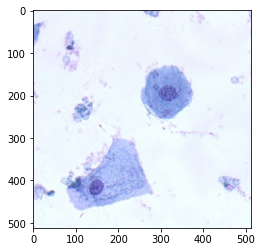

In [2]:
#read source image
img_source=Image.open("assets/3_color_net_neg23570_ori.png")
plt.imshow(img_source)


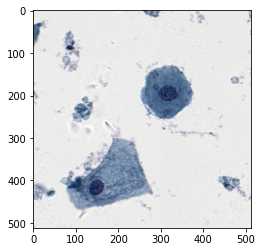

In [3]:
#read target image
img_target=Image.open("assets/3_color_net_neg23570_target.png") 
plt.imshow(img_target)

In [4]:
#load  pretrained StainNet
model_Net = StainNet().cuda()
model_Net.load_state_dict(torch.load("checkpoints/StainNet/StainNet-3x0_best_psnr_layer3_ch32.pth"))

<All keys matched successfully>

In [5]:
def norm(image):
    image = np.array(image).astype(np.float32)
    image = image.transpose((2, 0, 1))
    image = ((image / 255) - 0.5) / 0.5
    image=image[np.newaxis, ...]
    image=torch.from_numpy(image)
    return image

def un_norm(image):
    image = image.cpu().detach().numpy()[0]
    image = ((image * 0.5 + 0.5) * 255).astype(np.uint8).transpose((1,2,0))
    return image


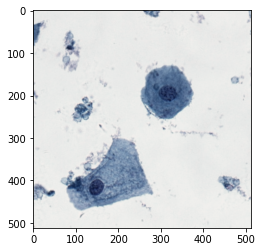

In [6]:
# run normlization
image_net=model_Net(norm(img_source).cuda())
image_net=un_norm(image_net)
plt.imshow(image_net)

In [7]:
#load  pretrained StainGAN
model_GAN = ResnetGenerator(3, 3, ngf=64, norm_layer=nn.InstanceNorm2d, n_blocks=9).cuda().cuda()
model_GAN.load_state_dict(torch.load("checkpoints/StainGAN/latest_net_G_A.pth"))

<All keys matched successfully>

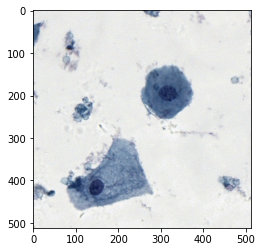

In [8]:
# run normlization
image_gan=model_GAN(norm(img_source).cuda())
image_gan=un_norm(image_gan)
plt.imshow(image_gan)

reinhard


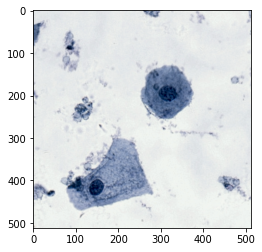

In [9]:
# run reinhard normlization
print("reinhard")
normalizer = staintools.ReinhardColorNormalizer()
normalizer.fit(np.array(img_target))
reinhard_normalized = normalizer.transform(np.array(img_source))
plt.imshow(reinhard_normalized)

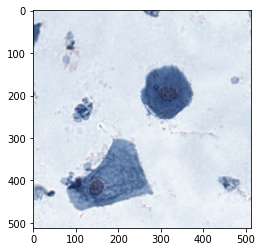

In [10]:
# run macenko normlization
normalizer = staintools.StainNormalizer(method="macenko")
normalizer.fit(np.array(img_target))
macenko_normalized = normalizer.transform(np.array(img_source))
plt.imshow(macenko_normalized)

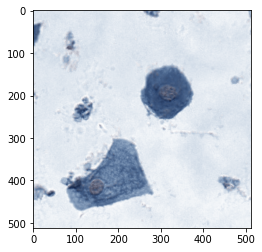

In [11]:
# run vahadane normlization
normalizer = staintools.StainNormalizer(method="vahadane")
normalizer.fit(np.array(img_target))
vahadane_normalized = normalizer.transform(np.array(img_source))
plt.imshow(vahadane_normalized)

In [12]:
def test_deeplearning_fps(model, n_iters, batchsize):
    data = torch.rand(batchsize, 3, 512, 512).cuda()
    start_time = time.time()
    for i in tqdm(range(n_iters)):
        with torch.no_grad():
            outputs = model(data)
    process_time = time.time() - start_time
    print("FPS is ", n_iters * batchsize / process_time)
    
def test_traditional_fps(source_img, ref_img, method,n_iters):
    ref_img = np.array(ref_img)
    source_img = np.array(ref_img)
    if method == "reinhard":
        normalizer = staintools.ReinhardColorNormalizer()
    else:
        normalizer = staintools.StainNormalizer(method=method)
    normalizer.fit(np.array(ref_img))
    start = time.time()
    for i in tqdm(range(n_iters)):
        try:
            img1_normalized = normalizer.transform(source_img)
        except:
            pass
    need_time = time.time() - start
    print(method, "FPS is ", n_iters / need_time)

In [13]:
print("test StainNet FPS")
test_deeplearning_fps(model_Net,2000,50)

test StainNet FPS


100%|██████████| 2000/2000 [02:21<00:00, 14.11it/s]

FPS is  705.3359446585164


In [14]:
print("test StainGAN FPS")
test_deeplearning_fps(model_GAN,200, 10)

test StainGAN FPS


100%|██████████| 200/200 [02:06<00:00,  1.58it/s]

FPS is  15.817100565244816


In [15]:
test_traditional_fps(img_source, img_target, "reinhard",200)
test_traditional_fps(img_source, img_target , "macenko", 50)
test_traditional_fps(img_source, img_target,  "vahadane", 10)

  0%|          | 0/50 [00:00<?, ?it/s]

reinhard FPS is  84.46591315402846


100%|██████████| 50/50 [00:06<00:00,  7.43it/s]


macenko FPS is  7.427898204863443


100%|██████████| 10/10 [00:11<00:00,  1.13s/it]

vahadane FPS is  0.8841778689371091
